# *BEATS CT reconstruction pipeline*
Minimal [TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for data collected at the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/)

Created on:  23.05.2021 <br />
Last update: 09.10.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Code license: MIT
- Narrative license: CC-BY-NC-SA

Type `Ctrl` + `Enter` on a single cell to run it.

## Load experiment data
Enter the **sample_name** and the correct **output_dir** 

In [1]:
sample_name = "bee_yazeed-20231001T170032"
work_dir = "/mnt/PETRA/SED/BEATS/IH/"+sample_name
h5file = work_dir+"/"+sample_name+".h5"

output_dir = "/mnt/PETRA/SED/BEATS/IH/scratch/tmp/"
recon_dir = output_dir+sample_name+"/recon/"
cor_dir = output_dir+sample_name+"/cor/"

### Load the complete dataset (or)

In [ ]:
# projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0)

### Read a portion of the dataset
- `sino` controls the vertical detector lines to read - `sino=(1360, 2160, 1)`
- `proj` defines the range of projections - `proj=(1, 1001, 1)`

In [2]:
sino=(1360, 2160, 1)
proj=(1, 1001, 1)

In [4]:
projs, flats, darks, _ = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=sino, proj=proj)
theta = np.radians(dxchange.read_hdf5(h5file, 'exchange/theta', slc=(proj,)))

print("Dataset size: ", projs[:, :, :].shape[:], " - dtype: ", projs.dtype)
print("Flat fields size: ", flats[:, :, :].shape[:])
print("Dark fields size: ", darks[:, :, :].shape[:])
print("Theta array size: ", theta.shape[:])

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/bee_yazeed-20231001T170032/bee_yazeed-20231001T170032.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/bee_yazeed-20231001T170032/bee_yazeed-20231001T170032.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/bee_yazeed-20231001T170032/bee_yazeed-20231001T170032.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/bee_yazeed-20231001T170032/bee_yazeed-20231001T170032.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/bee_yazeed-20231001T170032/bee_yazeed-20231001T170032.h5


Dataset size:  (1000, 800, 2560)  - dtype:  uint16
Flat fields size:  (102, 800, 2560)
Dark fields size:  (102, 800, 2560)
Theta array size:  (1000,)


At any time you can take a look at your 3D data with `ru.plotmidplanes(data)`

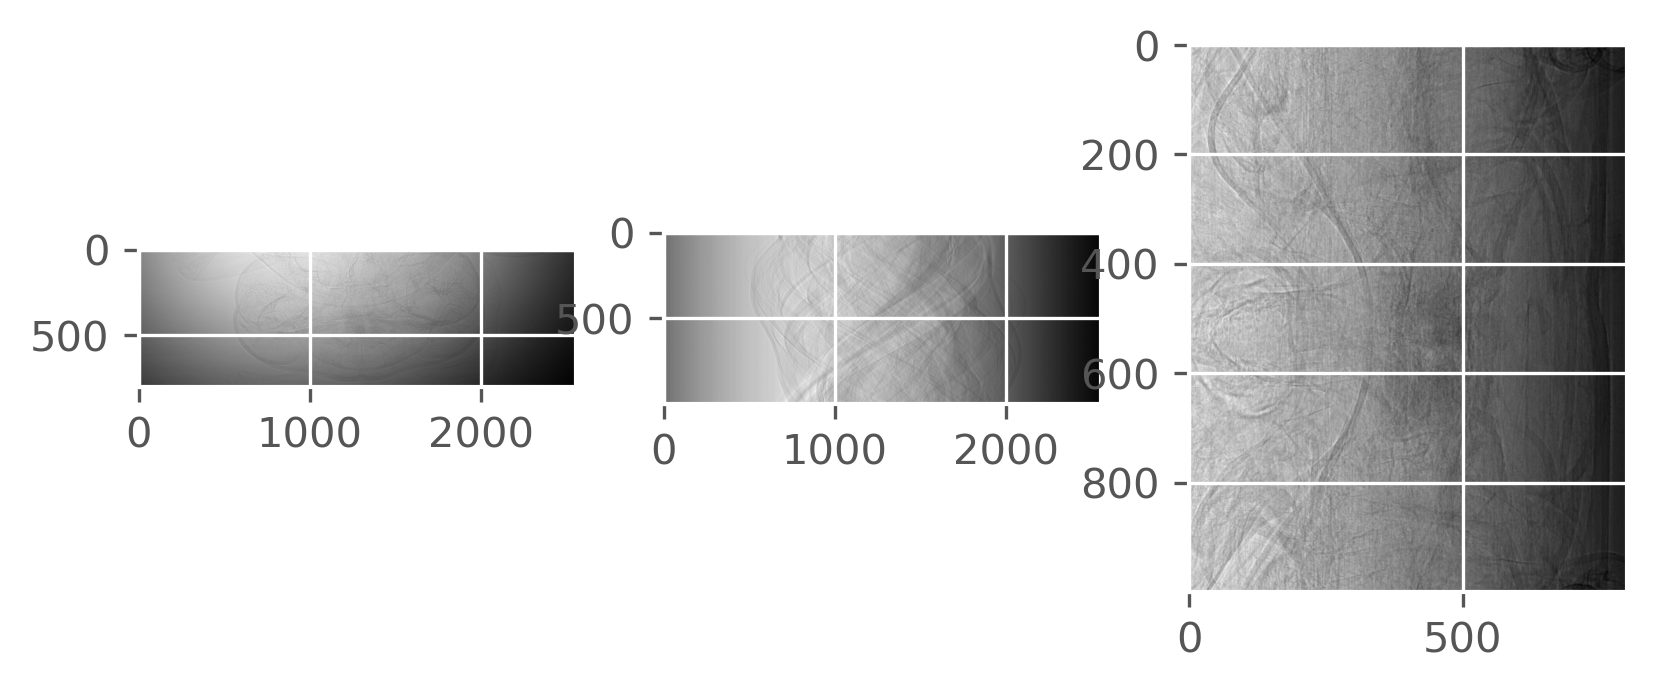

In [5]:
ru.plot_midplanes(projs)

## Flat field correction
Normalize the image background.

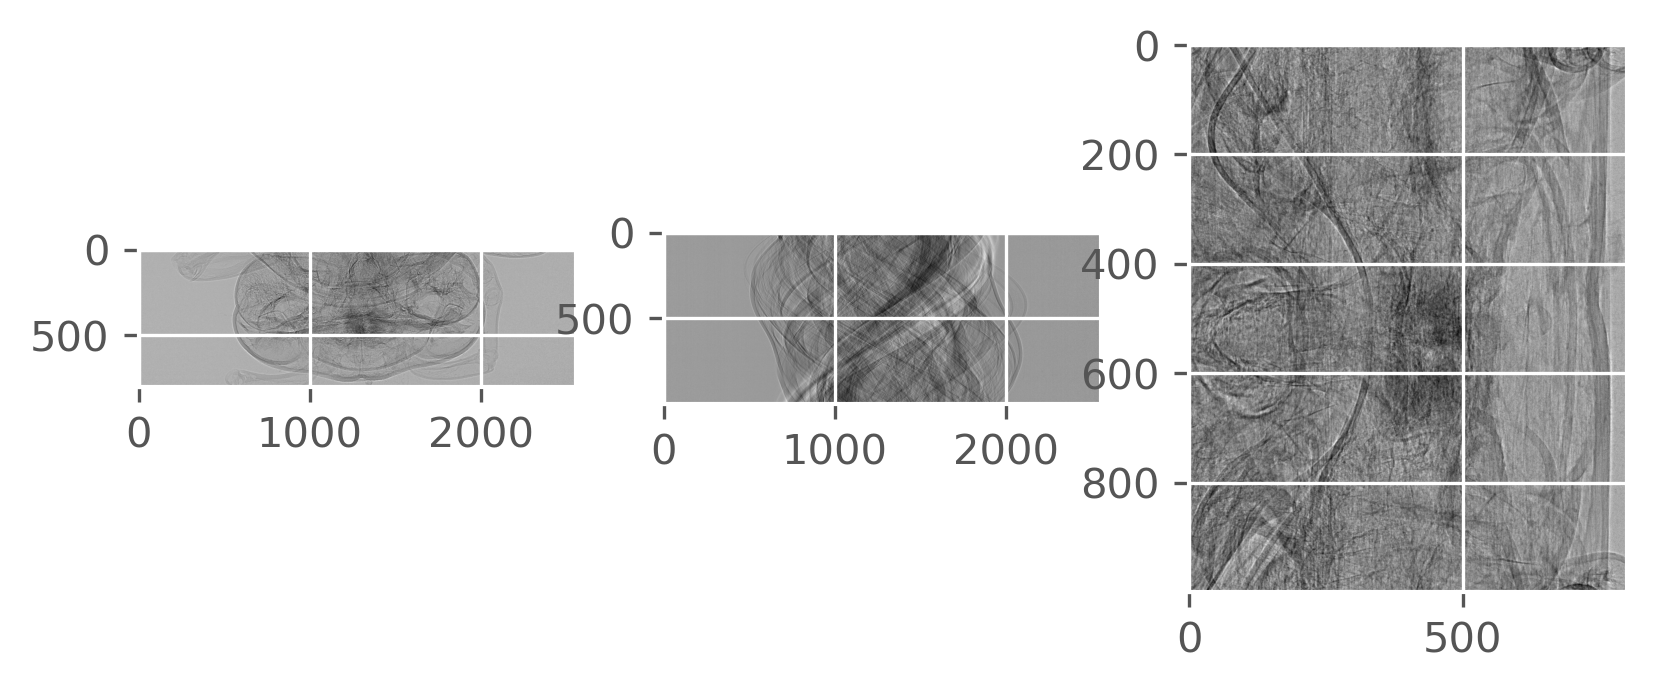

In [6]:
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median')
ru.plot_midplanes(projs)

## Log transform
Calculate $ -log(projs) $ to linearize transmission tomography data.

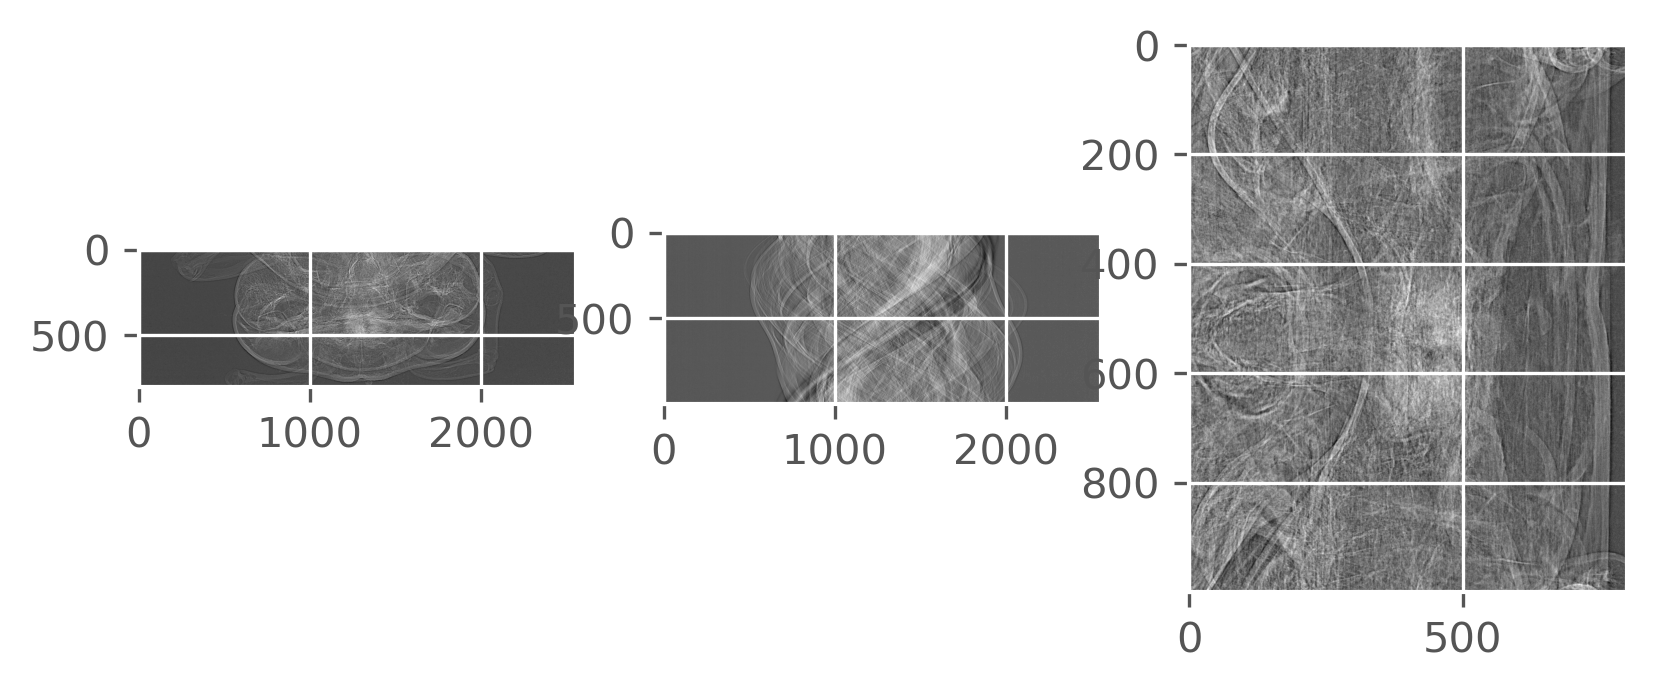

In [7]:
projs = tomopy.minus_log(projs, ncore=ncore)
ru.plot_midplanes(projs)

## Center Of Rotation (COR)
### Save images reconstructed with COR range

In [8]:
cor_range = [1298, 1304, 0.5]

In [9]:
tomopy.write_center(projs, theta, cor_dir, cor_range)

INFO:tomopy.recon.algorithm:Reconstructing 12 slice groups with 12 master threads...


View them in Fiji

In [10]:
# os.system(Fiji_exe_stack + cor_dir+'{:04.2f}'.format(COR[0])+'.tiff &')

Manually insert the best `COR`

In [11]:
COR = 1301

### Automatic detect COR

In [12]:
# COR = tomopy.find_center(projs, theta, init=projs.shape[2]/2, tol=0.5) # ind=200, 
# print("Automatic detected COR: ", COR, " - tomopy.find_center")

COR = tomopy.find_center_vo(projs, ncore=ncore)
print("Automatic detected COR: ", COR, " - tomopy.find_center_vo")

Automatic detected COR:  1301.5  - tomopy.find_center_vo


## Reconstruction
### CPU reconstruction of the entire dataset
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [13]:
recon = tomopy.recon(projs,
                     theta,
                     center=COR,
                     algorithm='gridrec',
                     sinogram_order=False,
                     ncore=ncore)

INFO:tomopy.recon.algorithm:Reconstructing 36 slice groups with 36 master threads...


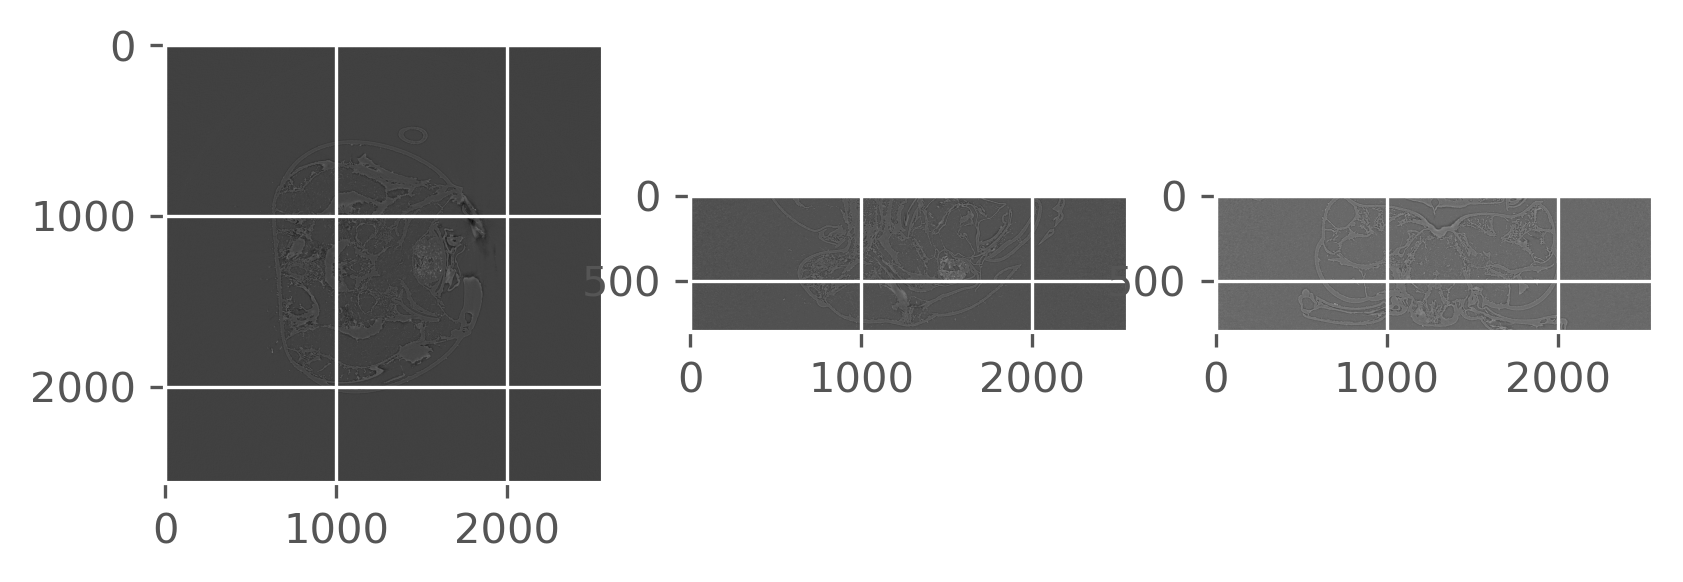

In [14]:
ru.plot_midplanes(recon)

### GPU reconstruction with the ASTRA toolbox
|  |  |
| :--- | :--- |
| **Algorithm**      | `fbp CUDA ASTRA` |

In [ ]:
# options = {'proj_type': 'cuda', 'method': 'FBP_CUDA'}

# recon = tomopy.recon(projs,
#                      theta,
#                      center=COR,
#                      algorithm=tomopy.astra,
#                      options=options,
#                      ncore=1)

## Write reconstructed dataset
Write output tiff stack as `float32`

In [15]:
fileout = recon_dir+'slice.tiff'
dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

Open virtual stack in ImageJ

In [ ]:
# os.system(Fiji_exe_stack + fileout + ' &')